In [1]:
# # Instantiate package environment for this notebook
using Pkg; pkg"instantiate"

In [2]:
using SpecialFunctions
using Unitful, Plots
using Random, Distributions,StatsBase, LinearAlgebra, Noise
using HDF5
using JLD2, FileIO
using SolidStateDetectors
using GePixDet
T = Float64;

## Define size of the detector to be simulated
-Example of notebook to generate automatically a SSD config file of a pixelated germanium detector to calculate the fields

-The number of pixels can be given and with the information of pixel pitch and pixel size it will generate a config file

In [3]:
#here define the reduced geometry of the detector to be simulated
#in general an array of 3x3 is a good representation or even just one pixel 
#if you don't want to study cross-talk or charge sharing effects
N_pixels_x = 3
N_pixels_y = 3
pitch = 75
inter_pixel_um = 12
pixel_size = pitch - inter_pixel_um
pitch = pixel_size + inter_pixel_um #to be verified, maybe the 75 um is the pitch? 
crystal_x = N_pixels_x * pitch
crystal_y = N_pixels_y * pitch
crystal_z = 320
contact_thickness = 0.005 #assume just 5 nm Al evaporated contac? 
grid_z = crystal_z/2 + 1*pixel_size
grid_x = crystal_x/2 + 1*pixel_size
grid_y = crystal_y/2 + 1*pixel_size

175.5

In [4]:
println("Details of sensor: pitch = $(pitch), pixel size = $(pixel_size)")

Details of sensor: pitch = 75, pixel size = 63


In [5]:
#find coordinates of first pixel
x_first_pixel = -crystal_x/2 + (crystal_x - (N_pixels_x * pitch))/2
y_first_pixel = -crystal_y/2 + (crystal_y - (N_pixels_y * pitch))/2

-112.5

In [6]:
#Define the config file here, should work fine for square pixels, but adjust the voltage and doping concentration if needed
grid_part = "name: UFXC 
units:
  length: um
  angle: deg
grid:
  coordinates: cartesian
  axes:
   x: 
     from: -$(grid_x)
     to: $(grid_x)
   y:
     from: -$(grid_y)
     to: $(grid_y)
   z:
     from: -$(grid_z)
     to: $(grid_z)
medium: vacuum
detectors:
- semiconductor:
    material: Si
    impurity_density:
      name: constant
      value: 5e10cm^-3 
    geometry:
      box:
        widths: [$(crystal_x), $(crystal_y), $(crystal_z)]
        origin: [0,0,0]
  contacts:
  - material: Al
    name: \"Cathode\"
    id: 1
    potential: 200
    geometry:
       box:
         widths: [$(crystal_x), $(crystal_y), $(contact_thickness)]
         origin: [0,0,$(crystal_z/2)]"

total_contacts = ""
counter = 2
center_z_pixel = round(-crystal_z/2,digits = 3)
for i = 1 : 1 : N_pixels_x
    for j = 1 : 1 : N_pixels_y
        center_x = x_first_pixel + pitch/2 + (i-1)*pitch
        center_y = y_first_pixel + pitch/2 + (j-1)*pitch
        center_x_pixel = round(center_x,digits = 2)
        center_y_pixel = round(center_y,digits = 2)
        contact ="
  - material: Al
    name: \"pixel_$(counter-1)\"
    id: $(counter)
    potential: -1
    geometry:
       box:
         widths: [$(pixel_size), $(pixel_size), $(contact_thickness)]
         origin: [$(center_x_pixel),$(center_y_pixel),$(center_z_pixel)]
"
        total_contacts *=contact
        counter +=1
    end
end

####passives
pas="
  passives:
"
total_passives = ""
counter +=1
center_z_pixel = round(-crystal_z/2,digits = 3)
for i = 1 : 1 : N_pixels_x
    for j = 1 : 1 : N_pixels_y
        center_x = x_first_pixel + pitch/2 + (i-1)*pitch
        center_y = y_first_pixel + pitch/2 + (j-1)*pitch
        center_x_pixel = round(center_x,digits = 2)
        center_y_pixel = round(center_y,digits = 2)
        passive ="
  - name: Passivated Surface $(counter-1)
    id: $(counter)
    material: Si
    potential: 3
    geometry:
       difference: 
          - box: 
              widths: [$(pitch), $(pitch), $(contact_thickness)]
              origin: [$(center_x_pixel),$(center_y_pixel),$(center_z_pixel)]
          - box: 
              widths: [$(pixel_size), $(pixel_size), $(2*contact_thickness)]
              origin: [$(center_x_pixel),$(center_y_pixel),$(center_z_pixel)]
"
        total_passives *=passive
        counter +=1
    end
end
total_config_file = grid_part * total_contacts * pas * total_passives;

In [7]:
open("/home/experiences/detecteurs/manzanillas/SSD/UFXC/config_files/UFXC_squares_size_$(pixel_size)um_interpixel_$(inter_pixel_um)um.yaml", "w") do io
           write(io, total_config_file)
       end;

## Calculate the fields 
-Here we just read the config file generated in the last step and perform the calculation of the fields

In [8]:
mysim = Simulation{T}("/home/experiences/detecteurs/manzanillas/SSD/UFXC/config_files/UFXC_squares_size_$(pixel_size)um_interpixel_$(inter_pixel_um)um.yaml");

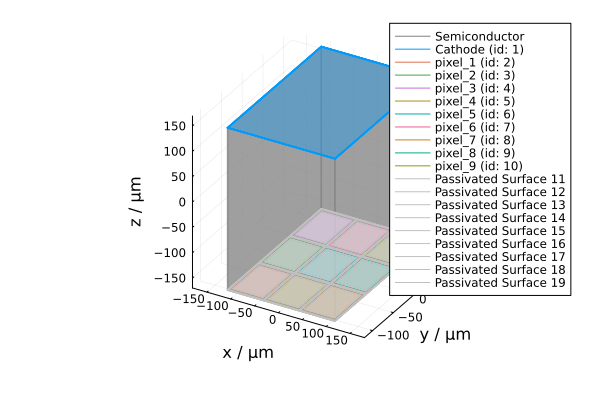

In [9]:
plot(u"μm",u"μm",u"μm")
plot!(mysim.detector.semiconductor, apect_ratio=:auto,seriestype = :mesh3d)
plot!(mysim.detector)

## Fields computation 

In [10]:
#degree of refinement can be adjusted
#use at least refinement_limits = [0.2, 0.1, 0.05, 0.03, 0.01] for the final file
calculate_electric_potential!(mysim, depletion_handling = true, min_tick_distance = 10u"nm",refinement_limits = [0.2, 0.1, 0.05, 0.03, 0.01])

Simulation: UFXC
Electric Potential Calculation
Bias voltage: 201.0 V
Precision: Float64
Device: CPU
Max. CPU Threads: 24
Coordinate system: Cartesian
N Refinements: -> 5
Convergence limit: 1.0e-7  => 2.0e-5 V
Initial grid size: (30, 30, 10)

Grid size: (34, 34, 16) - using 24 threads now:
Grid size: (46, 46, 30) - using 24 threads now:
Grid size: (68, 68, 62) - using 24 threads now:
Grid size: (98, 98, 94) - using 24 threads now:
Grid size: (238, 238, 236) - using 24 threads now:


In [11]:
#to check if the detector is depleted
#if the detector is not depleted, probably the doping concentration is not correct
is_depleted(mysim.point_types)

true

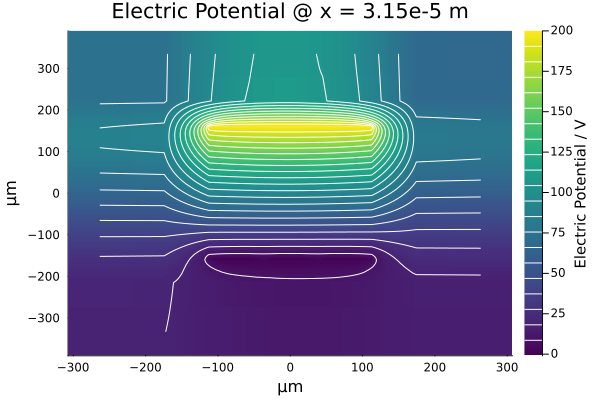

In [12]:
plot(mysim.electric_potential, yunit=u"μm", xunit=u"μm", x=30/1e6,aspect_ratio = :auto, contours_equal_potential = true,linecolor = :white, levels = 20)

In [13]:
#compute the electric field
calculate_electric_field!(mysim)

In [14]:
#plot the electric field and electric field lines
plot(mysim.electric_field, aspect_ratio = :auto, yunit=u"μm", xunit=u"μm", size = (900, 300), c = cgrad(:inferno, scale = :exp))
plot_electric_fieldlines!(mysim,aspect_ratio = :auto, x=0/1e6,sampling = 2u"μm",offset = 1.0u"μm")

In [15]:
#Here we just give the coordinates + energy of the hits in the detector
starting_positions = [ CartesianPoint{T}( 0/1e6, 4/1e6, 120/1e6 )]
energy_depos = T[10] * u"keV" 
evt = Event(starting_positions, energy_depos);

time_step = 0.01u"ns"
drift_charges!(evt, mysim, Δt = time_step)

plot(u"μm",u"μm",u"μm")
plot!(mysim.detector, size = (500, 500),legend=:false)
plot!(evt.drift_paths)

In [16]:
#Compute the WP of all contacts
#Adjust the refinement for your final file : refinement_limits = [0.2, 0.1,0.05, 0.03, 0.01]
for contact in mysim.detector.contacts
    calculate_weighting_potential!(mysim, contact.id, min_tick_distance = 10u"nm",refinement_limits = [0.2, 0.1,0.05, 0.03, 0.01], verbose = false)
end

In [17]:
#plot the WP
mycontact = 5
plot(mysim.weighting_potentials[mycontact],yunit=u"μm", xunit=u"μm",
      x=0.0/1e6,
      title = "",
    aspect_ratio = :auto,
      contours_equal_potential = true)

In [28]:
#Save the file
#uncomment next line if you want to save the file
#FileIO.save("/lustre/work/experiences/detecteurs/manzanillas/SSD/UFXC_9pixels_refniement001.jld2", Dict("Simulation" => mysim))

In [29]:
# simulate the event with the info x,y,z,E provided before
simulate!(evt, mysim,Δt = time_step,diffusion = true, self_repulsion = true) 

In [30]:
#transfer function to be convoluted with perfect waveforms
#assuming just a gaussian transfer function, to be adjusted if more information is known
d = Normal(0,2)
x = rand(d, 10^6)
h = fit(Histogram, x, -6.5:1.0:6.5)
h_n=normalize(h, mode=:pdf)
transfer_function = vcat(zeros(1),h_n.weights[1:end]);
plot(transfer_function)

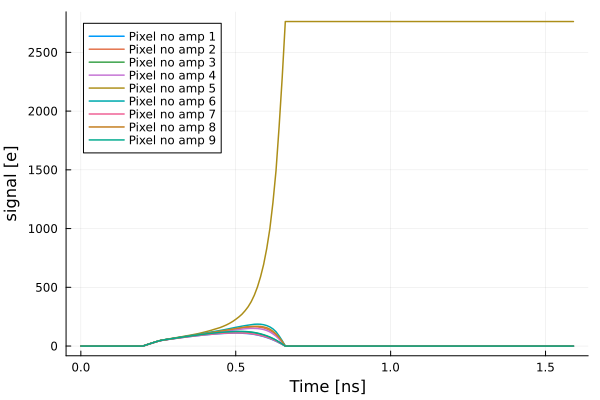

In [31]:
#just add baseline (zeros) and a tail(repeat the last value) for visualization purposes
wfs_with_tail = add_baseline_and_extend_tail.(evt.waveforms[2:end],20,160);
wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function))
plot(wfs_with_tail, lw = 1.5, label="Pixel no amp ".*string.((1:9)'), xlabel = "Time", legend = true)
#plot!(wfs_with_tail_amp, lw = 1.5, label="Pixel amp".*string.((1:1)'), xlabel = "Time", legend = true)

In [32]:
#complete;y arbitrary, probably there is a better way to estimate the dt between events
Φ = 1e3*(N_pixels_x*N_pixels_y)
μ = 1/(Φ/1e9) #convert time between events
σ = sqrt(μ )
d = Normal(μ,σ)

Normal{Float64}(μ=111111.11111111111, σ=333.3333333333333)